# TTT4185 Machine learning for Speech technology

# Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

In [28]:
# this will fetch the Train.csv and Test.csv so you do not need to manually upload them. Just run this block for each session

! wget https://folk.ntnu.no/plparson/ttt4185_data/Train.csv
! wget https://folk.ntnu.no/plparson/ttt4185_data/Test.csv

--2025-10-26 11:44:49--  https://folk.ntnu.no/plparson/ttt4185_data/Train.csv
Resolving folk.ntnu.no (folk.ntnu.no)... 2001:700:300:3::95, 129.241.56.95
Connecting to folk.ntnu.no (folk.ntnu.no)|2001:700:300:3::95|:443... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://plparson.folk.ntnu.no/ttt4185_data/Train.csv [following]
--2025-10-26 11:44:50--  https://plparson.folk.ntnu.no/ttt4185_data/Train.csv
Resolving plparson.folk.ntnu.no (plparson.folk.ntnu.no)... 2001:700:300:3::95, 129.241.56.95
Connecting to plparson.folk.ntnu.no (plparson.folk.ntnu.no)|2001:700:300:3::95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042638 (1.9M) [text/csv]
Saving to: ‘Train.csv.8’

Train.csv.8         100%[===================>]   1.95M  1.41MB/s    in 1.4s    

2025-10-26 11:44:52 (1.41 MB/s) - ‘Train.csv.8’ saved [2042638/2042638]

--2025-10-26 11:44:52--  https://folk.ntnu.no/plparson/ttt4185_data/Test.csv
Resolving folk.ntnu.no

## Problem 1: Maximum Likelihood

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.



### Task 1

Download the files `Train.csv` and `Test.csv` from Blackboard then upload them to your Colab workspace. You can load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

  SpeakerID Gender Phoneme        F1        F2        F3        F4        B1  \
0      cjf0      F      h#  0.701982  2.125440  2.433528  3.530050  0.264459   
1      cjf0      F       q  0.340942  2.594934  2.788244  4.028250  0.282159   
2      cjf0      F      iy  0.487078  2.605132  3.093409  4.354061  0.174520   
3      cjf0      F       v  0.505536  2.034326  2.804329  4.130655  0.190478   
4      cjf0      F      ih  0.524527  2.055382  2.989248  4.480000  0.164466   

         B2        B3        B4  
0  0.326273  0.300301  0.410096  
1  0.471724  0.310578  0.505835  
2  0.340025  0.232818  0.413965  
3  0.307295  0.301741  0.370238  
4  0.312337  0.301859  0.362134  


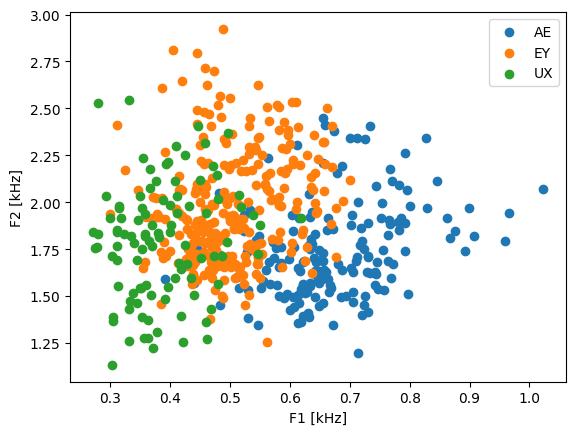

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

print(train.head())

# Extract vowels
train = train[train['Phoneme'].isin(['ae', 'ey', 'ux'])]
test = test[test['Phoneme'].isin(['ae', 'ey', 'ux'])]

# Plotting here••••••••••••••
ae_train_mask = train["Phoneme"].isin(["ae"])
ey_train_mask = train["Phoneme"].isin(["ey"])
ux_train_mask = train["Phoneme"].isin(["ux"])

ae_train_data = train.loc[ae_train_mask, ["F1", "F2"]].to_numpy()
ey_train_data = train.loc[ey_train_mask, ["F1", "F2"]].to_numpy()
ux_train_data = train.loc[ux_train_mask, ["F1", "F2"]].to_numpy()

plt.scatter(ae_train_data[:, 0], ae_train_data[:, 1], label="AE")
plt.scatter(ey_train_data[:, 0], ey_train_data[:, 1], label="EY")
plt.scatter(ux_train_data[:, 0], ux_train_data[:, 1], label="UX")
plt.xlabel("F1 [kHz]")
plt.ylabel("F2 [kHz]")
plt.legend()
plt.show()

### Task 2

 Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [30]:
class BDRClassifier:
    def __init__(self, ae_train_data: np.ndarray, ey_train_data: np.ndarray, ux_train_data):
        self.ae_train_data = ae_train_data
        self.ey_train_data = ey_train_data
        self.ux_train_data = ux_train_data
    
    def train(self):
        # Calculate means
        self.ae_mu = np.mean(self.ae_train_data,axis=0)
        self.ey_mu = np.mean(self.ey_train_data,axis=0)
        self.ux_mu = np.mean(self.ux_train_data,axis=0)
        # Calculate covariances
        self.ae_sigma = np.cov(self.ae_train_data, rowvar=False, ddof=1)
        self.ey_sigma = np.cov(self.ey_train_data, rowvar=False, ddof=1)
        self.ux_sigma = np.cov(self.ux_train_data, rowvar=False, ddof=1)
    
    def test(self, test_data: np.ndarray, true_labels: np.ndarray):
        conf_mat = np.zeros((3, 3))
        # Get confusion matrix indices
        lbl_to_idx = {
            "ae": 0,
            "ey": 1,
            "ux": 2
        }
        # Increment matrix elements
        for idx, val in enumerate(test_data):
            pred_label = self.classify(val)
            true_label = true_labels[idx]
            i = lbl_to_idx[true_label]
            j = lbl_to_idx[pred_label]
            conf_mat[i, j] += 1
        # Print result
        print(conf_mat)
        return conf_mat

    def gaussian(self, x: np.ndarray, mu: np.ndarray, sigma: np.ndarray):
        sigma_inv = np.linalg.inv(sigma)
        norm_factor = 1 / (2*np.pi * np.sqrt(np.linalg.det(sigma)))
        quad_form = (x - mu).T @ sigma_inv @ (x - mu)
        return norm_factor * np.exp(-0.5 * quad_form)

    def classify(self, x: np.ndarray):
        classes = ["ae", "ey", "ux"]
        probs = [self.gaussian(x, self.ae_mu, self.ae_sigma),
                 self.gaussian(x, self.ey_mu, self.ey_sigma),
                 self.gaussian(x, self.ux_mu, self.ux_sigma)]
        idx = np.argmax(probs)
        return classes[idx]

    def plotGaussians(self, ax, res=1000.0, showDecision=True, showData=False):
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/res, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/res]
        xy = np.dstack((x, y))

        # ae
        ae_mvn = scipy.stats.multivariate_normal(self.ae_mu, self.ae_sigma)
        ae_lik = ae_mvn.pdf(xy)
        ax.contour(x, y, ae_lik, colors="red")

        # ey
        ey_mvn = scipy.stats.multivariate_normal(self.ey_mu, self.ey_sigma)
        ey_lik = ey_mvn.pdf(xy)
        ax.contour(x, y, ey_lik, colors="green")

        # ux
        ux_mvn = scipy.stats.multivariate_normal(self.ux_mu, self.ux_sigma)
        ux_lik = ux_mvn.pdf(xy)
        ax.contour(x, y, ux_lik, colors="blue")

        if showDecision:
            decision_regions = np.argmax(np.array([ae_lik, ey_lik, ux_lik]), axis=0)
            ax.contourf(x, y, decision_regions, alpha=0.3, cmap="viridis")
        
        if showData:
            ax.scatter(self.ae_train_data[:, 0], self.ae_train_data[:, 1], label="AE", color="red")
            ax.scatter(self.ey_train_data[:, 0], self.ey_train_data[:, 1], label="EY", color="green")
            ax.scatter(self.ux_train_data[:, 0], self.ux_train_data[:, 1], label="UX", color="blue")
    
    def permutation_feature_test(self, test_data: np.ndarray, true_labels: np.ndarray, feature_names: list, n_permutations: int = 10):
        
        # Get baseline accuracy (correct predictions / total predictions)
        lbl_to_idx = {"ae": 0, "ey": 1, "ux": 2}
        baseline_correct = 0
        for idx, val in enumerate(test_data):
            pred_label = self.classify(val)
            true_label = true_labels[idx]
            if pred_label == true_label:
                baseline_correct += 1
        baseline_accuracy = baseline_correct / len(test_data)
        feature_importance = {}
        
        print(f"Baseline accuracy: {baseline_accuracy:.4f}")
        print("\nPermutation feature importance:")
        print("-" * 50)
        
        # Test each feature
        n_features = test_data.shape[1]
        for feature_idx in range(n_features):
            feature_name = feature_names[feature_idx]
            accuracies = []
            
            for i in range(n_permutations):
                test_data_permuted = test_data.copy()
                np.random.shuffle(test_data_permuted[:, feature_idx])
                correct = 0
                for idx, val in enumerate(test_data_permuted):
                    pred_label = self.classify(val)
                    true_label = true_labels[idx]
                    if pred_label == true_label:
                        correct += 1
                accuracy = correct / len(test_data_permuted)
                accuracies.append(accuracy)
            
            mean_accuracy = np.mean(accuracies)
            importance = baseline_accuracy - mean_accuracy
            feature_importance[feature_name] = {
                'accuracies': accuracies,
                'mean_accuracy': mean_accuracy,
                'importance': importance
            }
            
            print(f"{feature_name:4s}: Mean accuracy = {mean_accuracy:.4f}, "
                  f"Importance (drop) = {importance:.4f}")
        
        # Find and display the most important feature
        print("-" * 50)
        most_important = max(feature_importance.items(), 
                            key=lambda x: x[1]['importance'])
        print(f"\nMost important feature: {most_important[0]} "
              f"(importance = {most_important[1]['importance']:.4f})")
        
        return feature_importance, baseline_accuracy
        

In [31]:
classifier = BDRClassifier(ae_train_data, ey_train_data, ux_train_data)

classifier.train()

x_test = np.array([0.8, 2])

print(classifier.classify(x_test))


ae


### Task 3

To visualize the classes models and the classifier created in Task 2, plot the contours for each Gaussian distribution in the model. That is, the class conditional likelihoods $P(x|c)$, by using the following function.

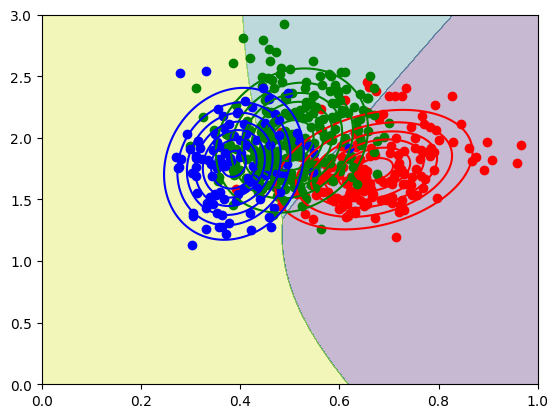

In [32]:
fig, ax = plt.subplots(1)
ax.set_xlim((0, 1))
ax.set_ylim((0, 3))

classifier.plotGaussians(ax, showData=True)

#### Optional

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

In [33]:
# Done above

### Task 4

Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_. That is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

In [34]:
ae_mask = test["Phoneme"].isin(["ae"])
ey_mask = test["Phoneme"].isin(["ey"])
ux_mask = test["Phoneme"].isin(["ux"])

test_data = test[["F1", "F2"]].to_numpy()
true_labels = test["Phoneme"].to_numpy()
  
classifier.test(test_data, true_labels)

[[90. 14.  1.]
 [14. 84. 16.]
 [ 2. 18. 32.]]


array([[90., 14.,  1.],
       [14., 84., 16.],
       [ 2., 18., 32.]])

### Task 5

Extend your classifier to include the features "F1"-"F4" and compare the results with those in Task 4.

In [35]:
classifier4D = BDRClassifier(train.loc[ae_train_mask, ["F1", "F2", "F3", "F4"]].to_numpy(),
                                train.loc[ey_train_mask, ["F1", "F2", "F3", "F4"]].to_numpy(),
                                train.loc[ux_train_mask, ["F1", "F2", "F3", "F4"]].to_numpy())

classifier4D.train()

test_data_4D = test[["F1", "F2", "F3", "F4"]].to_numpy()
classifier4D.test(test_data_4D, true_labels)

[[88. 15.  2.]
 [16. 89.  9.]
 [ 1. 16. 35.]]


array([[88., 15.,  2.],
       [16., 89.,  9.],
       [ 1., 16., 35.]])

### Task 6

Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

A bit better performance for "ey" and "ux", and a bit worse for "ae". Overall pretty similar.

### Task 6

Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

In [36]:
classifier8D = BDRClassifier(train.loc[ae_train_mask, ["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].to_numpy(),
                                train.loc[ey_train_mask, ["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].to_numpy(),
                                train.loc[ux_train_mask, ["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].to_numpy())

classifier8D.train()

test_data_8D = test[["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].to_numpy()
classifier8D.test(test_data_8D, true_labels)

[[88. 16.  1.]
 [16. 80. 18.]
 [ 2. 17. 33.]]


array([[88., 16.,  1.],
       [16., 80., 18.],
       [ 2., 17., 33.]])

Still quite similar, but now worse.

### Task 7

To better understand how important each feature is to the model, we will now perform permutation feature importance (https://scikit-learn.org/stable/modules/permutation_importance.html). The idea is that for each feature we will randomly shuffle the values and the ask the trained model to predict using this shuffled data. We can then observe how the performance degregates as each feature is shuffled.

For the model using all 8 features (all four formants and four bandwidths), shuffle and evaluate each feature 10 times. Which feature has the biggest impact on model performance? Does this align with your knowlege of formants?

Baseline accuracy: 0.7417

Permutation feature importance:
--------------------------------------------------


F1  : Mean accuracy = 0.4461, Importance (drop) = 0.2956
F2  : Mean accuracy = 0.6428, Importance (drop) = 0.0989
F3  : Mean accuracy = 0.6823, Importance (drop) = 0.0594
F4  : Mean accuracy = 0.7111, Importance (drop) = 0.0306
B1  : Mean accuracy = 0.6982, Importance (drop) = 0.0435
B2  : Mean accuracy = 0.7033, Importance (drop) = 0.0384
B3  : Mean accuracy = 0.7380, Importance (drop) = 0.0037
B4  : Mean accuracy = 0.7454, Importance (drop) = -0.0037
--------------------------------------------------

Most important feature: F1 (importance = 0.2956)


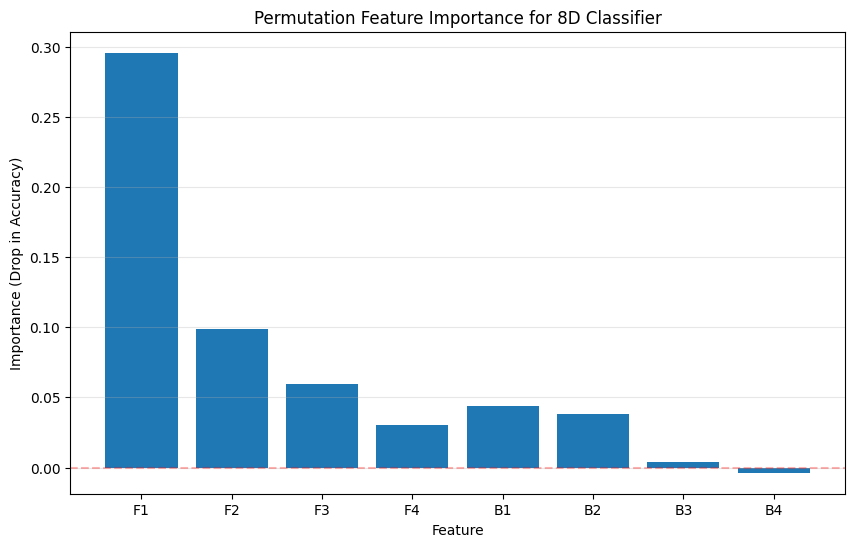

In [37]:
feature_names_8D = ["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]

importance_results, baseline_acc = classifier8D.permutation_feature_test(
    test_data_8D, 
    true_labels, 
    feature_names_8D, 
    n_permutations=10
)

# Visualize the results
import matplotlib.pyplot as plt

features = list(importance_results.keys())
importances = [importance_results[f]['importance'] for f in features]

plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.xlabel('Feature')
plt.ylabel('Importance (Drop in Accuracy)')
plt.title('Permutation Feature Importance for 8D Classifier')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Task 8

We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in Task 5.

In [38]:
class BDRConditionalClassifier:
     def __init__(self, train_data: pd.DataFrame, diag: bool = False):
          self.train_data = train_data
          self.diag = diag

     def train(self):
          self.combinations = [('M', 'ae'), ('M', 'ey'), ('M', 'ux'),
                                           ('F', 'ae'), ('F', 'ey'), ('F', 'ux')]
          self.means = {}
          self.covariances = {}
          self.priors = {}

          for gender, phoneme in self.combinations:
               # Get likelihood parameters
               subset = self.train_data[(self.train_data['Gender'] == gender) & (self.train_data['Phoneme'] == phoneme)]
               features = subset[['F1', 'F2', 'F3', 'F4']].to_numpy()
               mu = np.mean(features, axis=0)
               if self.diag:
                    sigma = np.diag(np.var(features, axis=0, ddof=1))
               else:
                    sigma = np.cov(features, rowvar=False, ddof=1)
               self.means[(gender, phoneme)] = mu
               self.covariances[(gender, phoneme)] = sigma
               # Get priors
               total_count = len(self.train_data)
               self.priors[(gender, phoneme)] = len(subset) / total_count

     def classify(self, x: np.ndarray):
          # Compute unnormalized posterior probabilities for each class
          posteriors = {}
          for gender, phoneme in self.combinations:
               prior = self.priors[(gender, phoneme)]
               likelihood = scipy.stats.multivariate_normal.pdf(x, mean=self.means[(gender, phoneme)], cov=self.covariances[(gender, phoneme)])
               posteriors[(gender, phoneme)] = prior * likelihood

          # Marginalize over gender
          marginalized_posteriors = {}
          for phoneme in ['ae', 'ey', 'ux']:
               marginalized_posteriors[phoneme] = sum(posteriors[(gender, phoneme)] for gender in ['M', 'F'])

          # Return the phoneme with the highest marginalized posterior probability
          return max(marginalized_posteriors, key=marginalized_posteriors.get)
     
     def test(self, test_data: np.ndarray, true_labels: np.ndarray):
          conf_mat = np.zeros((3, 3))
          # Get confusion matrix indices
          lbl_to_idx = {
               "ae": 0,
               "ey": 1,
               "ux": 2
          }

          for idx, val in enumerate(test_data):
               pred_label = self.classify(val)
               true_label = true_labels[idx]
               i = lbl_to_idx[true_label]
               j = lbl_to_idx[pred_label]
               conf_mat[i, j] += 1

          print(conf_mat)
          return conf_mat

Gender-conditional classifier (Task 8) - 4D features:
[[ 83.  21.   1.]
 [ 11. 100.   3.]
 [  4.  24.  24.]]

Standard classifier (Task 5) - 4D features:
[[88. 15.  2.]
 [16. 89.  9.]
 [ 1. 16. 35.]]


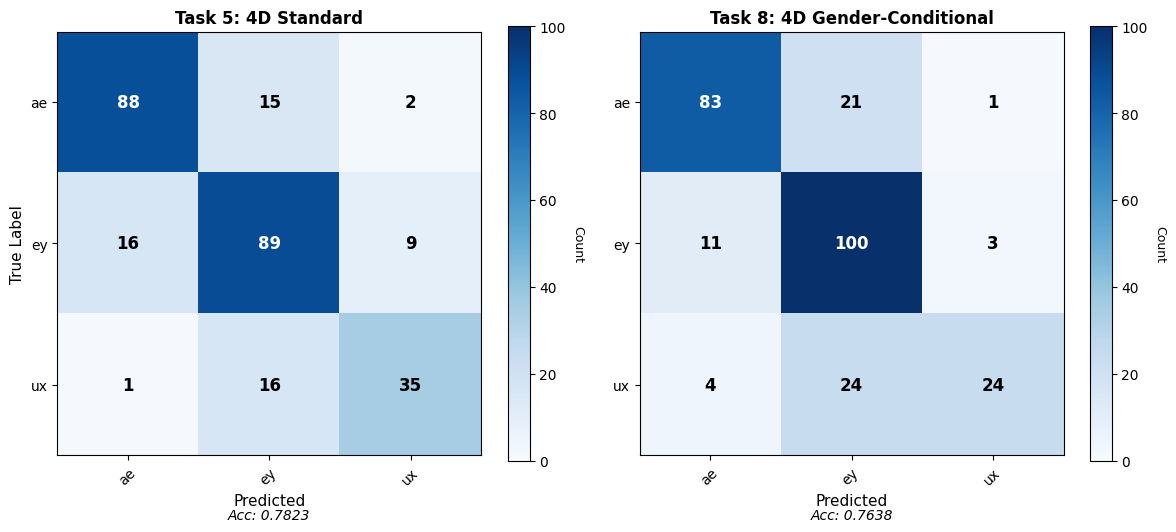

In [39]:
# Train and test the gender-conditional classifier with 4D features
cond_classifier = BDRConditionalClassifier(train)
cond_classifier.train()

print("Gender-conditional classifier (Task 8) - 4D features:")
cond_conf_mat = cond_classifier.test(test_data_4D, true_labels)

print("\nStandard classifier (Task 5) - 4D features:")
std_4d_conf_mat = classifier4D.test(test_data_4D, true_labels)

# Compare using the plotting function
plot_confusion_matrices(
    [std_4d_conf_mat, cond_conf_mat],
    ["Task 5: 4D Standard", "Task 8: 4D Gender-Conditional"],
)

It seems like it actually performs worse when marginalizing over gender. This could suggest that gender gives little information regarding the phoneme.

### Task 9

When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in Task 5 using only diagonal covariance matrices and compare the results.

Gender-conditional classifier with full matrix(Task 8) - 4D features:
[[ 83.  21.   1.]
 [ 11. 100.   3.]
 [  4.  24.  24.]]
Gender-conditional classifier with diagonal(Task 8) - 4D features:
[[82. 22.  1.]
 [14. 97.  3.]
 [ 1. 24. 27.]]

Standard classifier (Task 5) - 4D features:
[[88. 15.  2.]
 [16. 89.  9.]
 [ 1. 16. 35.]]


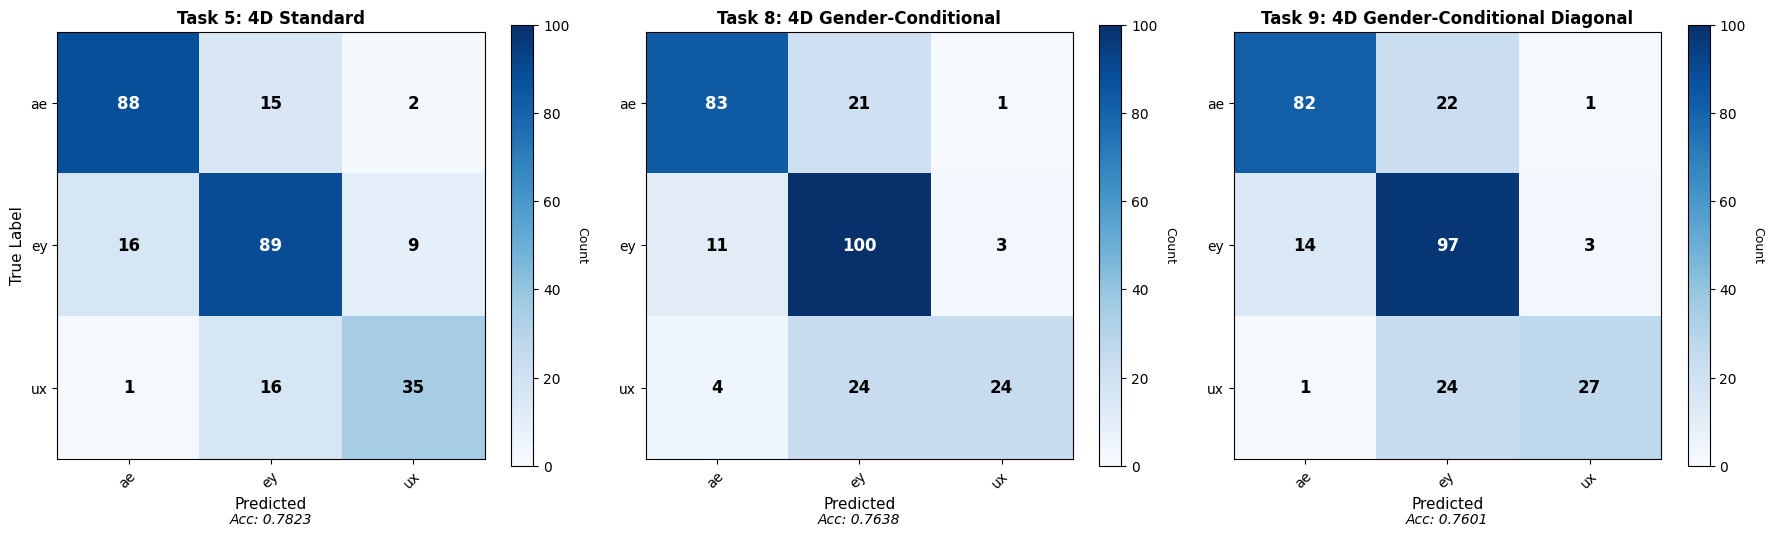

In [40]:
cond_classifier_diag = BDRConditionalClassifier(train, diag=True)
cond_classifier_diag.train()

print("Gender-conditional classifier with full matrix(Task 8) - 4D features:")
cond_conf_mat = cond_classifier.test(test_data_4D, true_labels)

print("Gender-conditional classifier with diagonal(Task 8) - 4D features:")
cond_conf_mat_diag = cond_classifier_diag.test(test_data_4D, true_labels)

print("\nStandard classifier (Task 5) - 4D features:")
std_4d_conf_mat_diag = classifier4D.test(test_data_4D, true_labels)

# Compare using the plotting function
plot_confusion_matrices(
    [std_4d_conf_mat_diag, cond_conf_mat, cond_conf_mat_diag],
    ["Task 5: 4D Standard", "Task 8: 4D Gender-Conditional", "Task 9: 4D Gender-Conditional Diagonal"],
)

It only performs slightly worse than when using the full covariance matrix. This would probably be useful to save computation time when working in larger dimension or with larger datasets.

## Problem 2: SVMs

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [41]:
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf: SVC, data: np.array, labels: np.array) -> None:
    '''
    This function is for plotting the decision area of SVM

    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    # we need to use the LabelEncoder here to make contourf work
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    sns.scatterplot(x = data[:,0], y = data[:,1],hue=labels)
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Decision Area of SVM')
    plt.show()

def Plot_Support_Vectors(clf: SVC, data: np.array) -> None:
    '''
    This function is for plotting the support vectors of the SVM model

    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # we need to use the LabelEncoder here to make contourf work
    label_encoder = LabelEncoder()
    Z = label_encoder.fit_transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

# Self defined functions

def svc_test(clf: SVC, x_test: np.ndarray, y_test: np.ndarray) -> np.ndarray:
    conf_mat = np.zeros((3, 3))
    lbl_to_idx = {
        "ae": 0,
        "ey": 1,
        "ux": 2
    }
    x_pred = clf.predict(x_test)
    for idx, pred_label in enumerate(x_pred):
        true_label = y_test[idx]
        conf_mat[lbl_to_idx[true_label], lbl_to_idx[pred_label]] += 1
    return conf_mat

def plot_confusion_matrix(conf_mat: np.ndarray, title: str = "Confusion Matrix", 
                          class_names: list = ["ae", "ey", "ux"]):
    """
    Plot a confusion matrix with nice formatting.
    
    Args:
        conf_mat: Confusion matrix (n_classes, n_classes)
        title: Title for the plot
        class_names: List of class names for labels
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create heatmap
    im = ax.imshow(conf_mat, cmap='Blues')
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    # Rotate the tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, int(conf_mat[i, j]),
                          ha="center", va="center", 
                          color="white" if conf_mat[i, j] > conf_mat.max() / 2 else "black",
                          fontsize=14, fontweight='bold')
    
    # Labels and title
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Calculate and display accuracy
    accuracy = np.trace(conf_mat) / np.sum(conf_mat)
    plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.4f}', 
                ha='center', fontsize=11, style='italic')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(conf_mats: list, titles: list, 
                            class_names: list = ["ae", "ey", "ux"],
                            figsize_per_plot: tuple = (6, 5)):
    """
    Plot multiple confusion matrices side by side.
    
    Args:
        conf_mats: List of confusion matrices
        titles: List of titles for each confusion matrix
        class_names: List of class names for labels
        figsize_per_plot: Size of each subplot (width, height)
    """
    n_plots = len(conf_mats)
    
    # Calculate figure size
    fig_width = figsize_per_plot[0] * n_plots
    fig_height = figsize_per_plot[1]
    
    fig, axes = plt.subplots(1, n_plots, figsize=(fig_width, fig_height))
    
    # Handle single plot case
    if n_plots == 1:
        axes = [axes]
    
    # Find global max for consistent color scaling
    vmax = max([mat.max() for mat in conf_mats])
    
    for idx, (conf_mat, title, ax) in enumerate(zip(conf_mats, titles, axes)):
        # Create heatmap
        im = ax.imshow(conf_mat, cmap='Blues', vmin=0, vmax=vmax)
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Count", rotation=-90, va="bottom", fontsize=9)
        
        # Set ticks and labels
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
        
        # Rotate the tick labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # Add text annotations
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                text = ax.text(j, i, int(conf_mat[i, j]),
                              ha="center", va="center", 
                              color="white" if conf_mat[i, j] > vmax / 2 else "black",
                              fontsize=12, fontweight='bold')
        
        # Labels and title
        ax.set_xlabel('Predicted', fontsize=11)
        if idx == 0:  # Only show ylabel on the first plot
            ax.set_ylabel('True Label', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        
        # Calculate and display accuracy
        accuracy = np.trace(conf_mat) / np.sum(conf_mat)
        ax.text(0.5, -0.15, f'Acc: {accuracy:.4f}', 
                transform=ax.transAxes, ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()

def train_and_compare_svms(svms: list, x_test: np.ndarray, y_test: np.ndarray, 
                            x_train: np.ndarray, y_train: np.ndarray):
    conf_mats = []
    titles = []
    for svm in svms:
        svm.fit(x_train, y_train)
        conf_mat = svc_test(svm, x_test, y_test)
        conf_mats.append(conf_mat)
        titles.append(f"SVM (C={svm.C}, kernel={svm.kernel})")
    plot_confusion_matrices(conf_mats, titles)

def eval_train_and_test_performance(svm: SVC, 
                                    x_train: np.ndarray, y_train: np.ndarray,
                                    x_test: np.ndarray, y_test: np.ndarray):
                                    
    train_conf_mat = svc_test(svm, x_train, y_train)
    test_conf_mat = svc_test(svm, x_test, y_test)
    plot_confusion_matrices([train_conf_mat, test_conf_mat], 
                            ["Training Set Confusion Matrix", "Test Set Confusion Matrix"])

### Task 10

Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

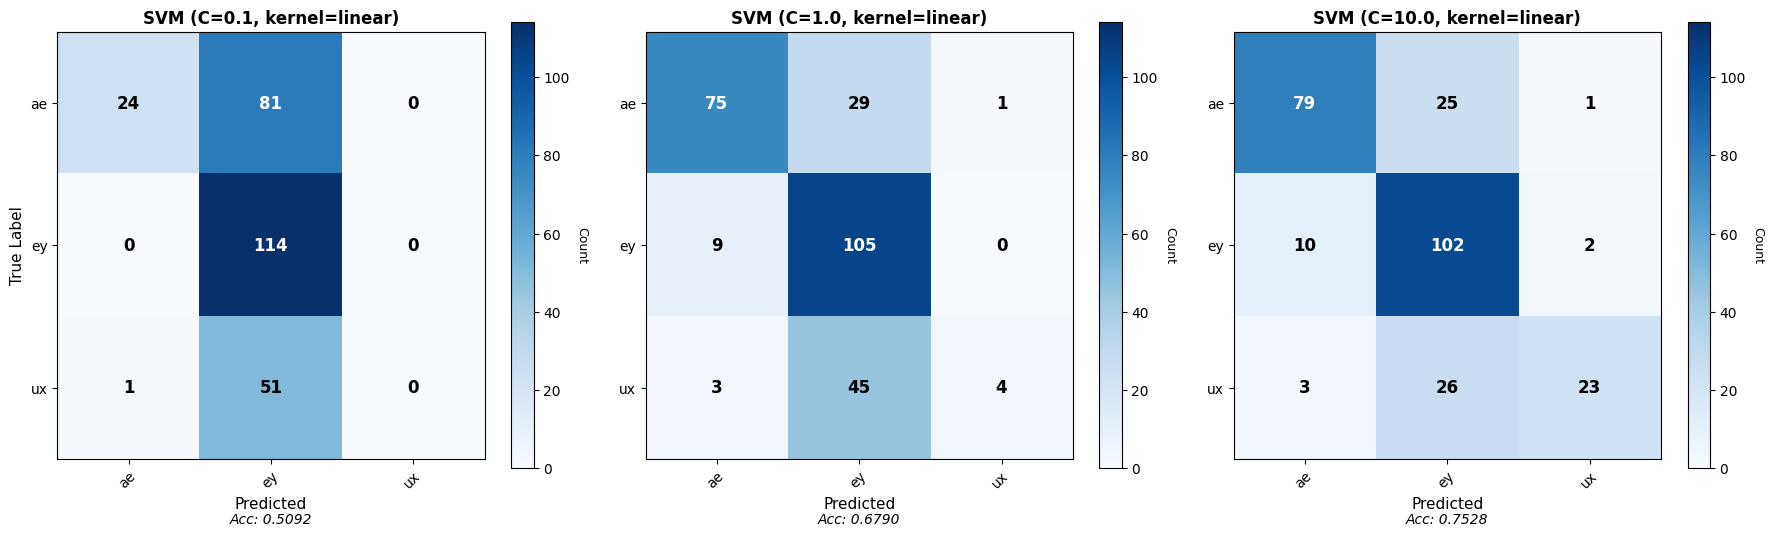

In [42]:
linear_svms = [SVC(kernel='linear', C=0.1),
                SVC(kernel='linear', C=1.0),
                SVC(kernel='linear', C=10.0)]

x_train = train[['F1', 'F2']].to_numpy()
y_train = train['Phoneme'].to_numpy()
x_test = test[['F1', 'F2']].to_numpy()
y_test = test['Phoneme'].to_numpy()

train_and_compare_svms(linear_svms, x_test, y_test, x_train, y_train)

### Task 11

Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

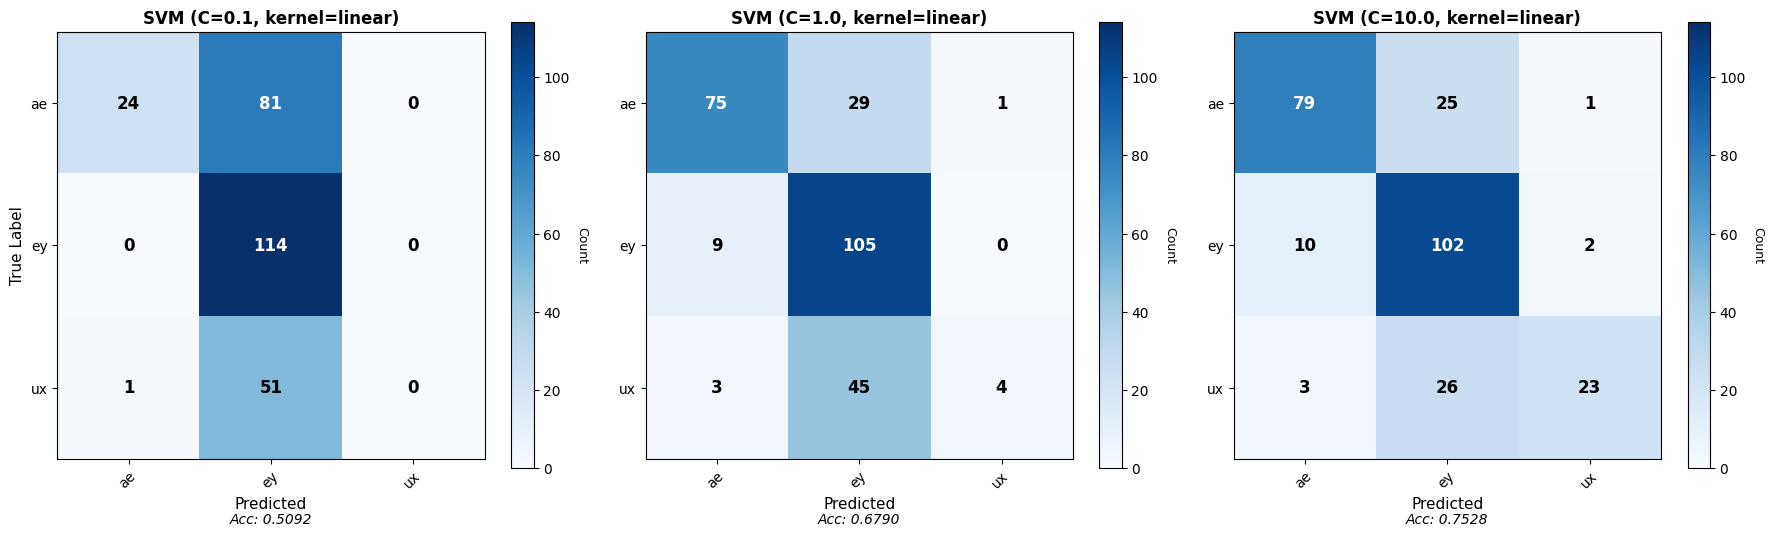

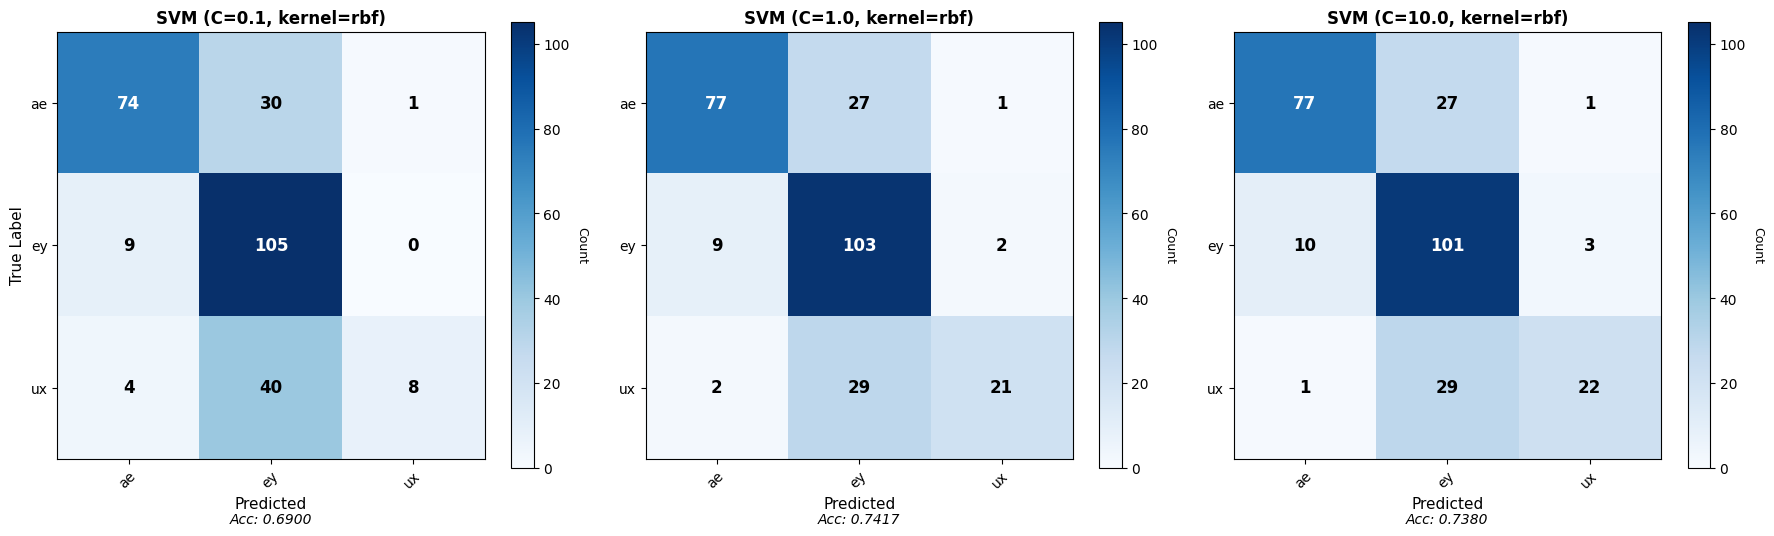

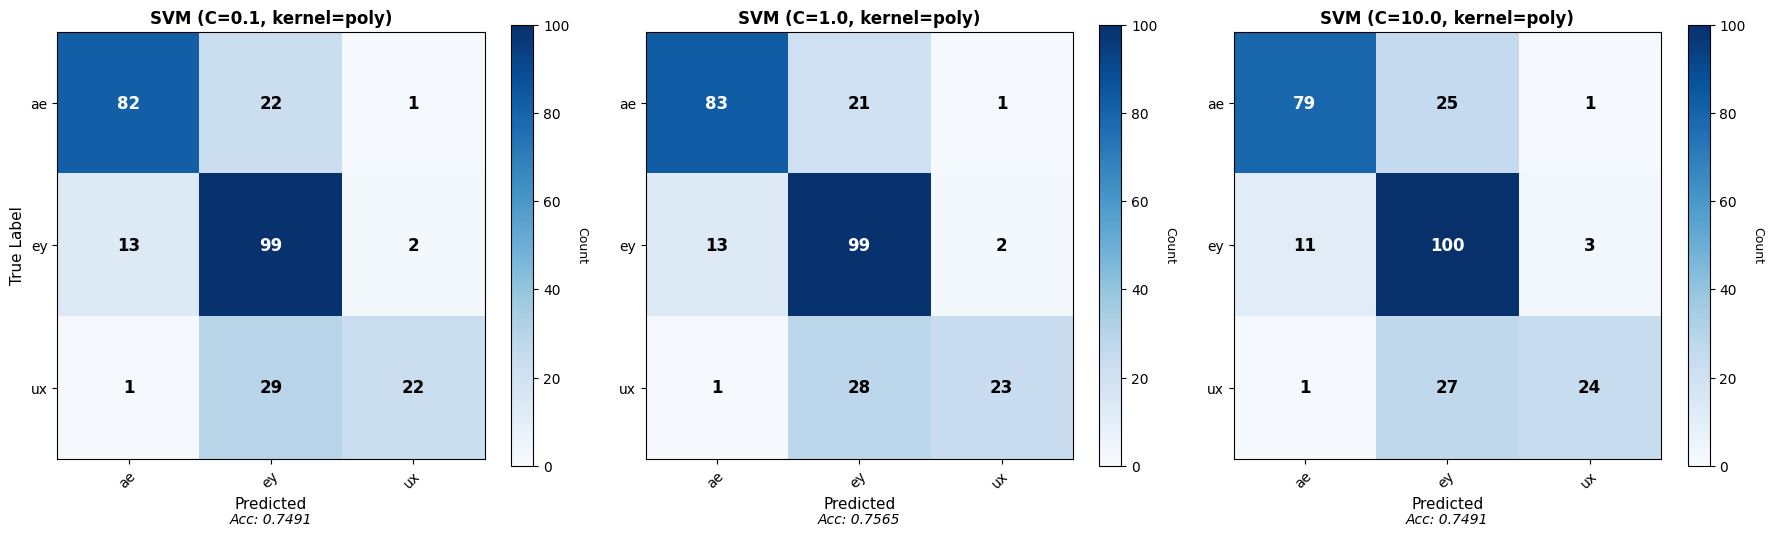

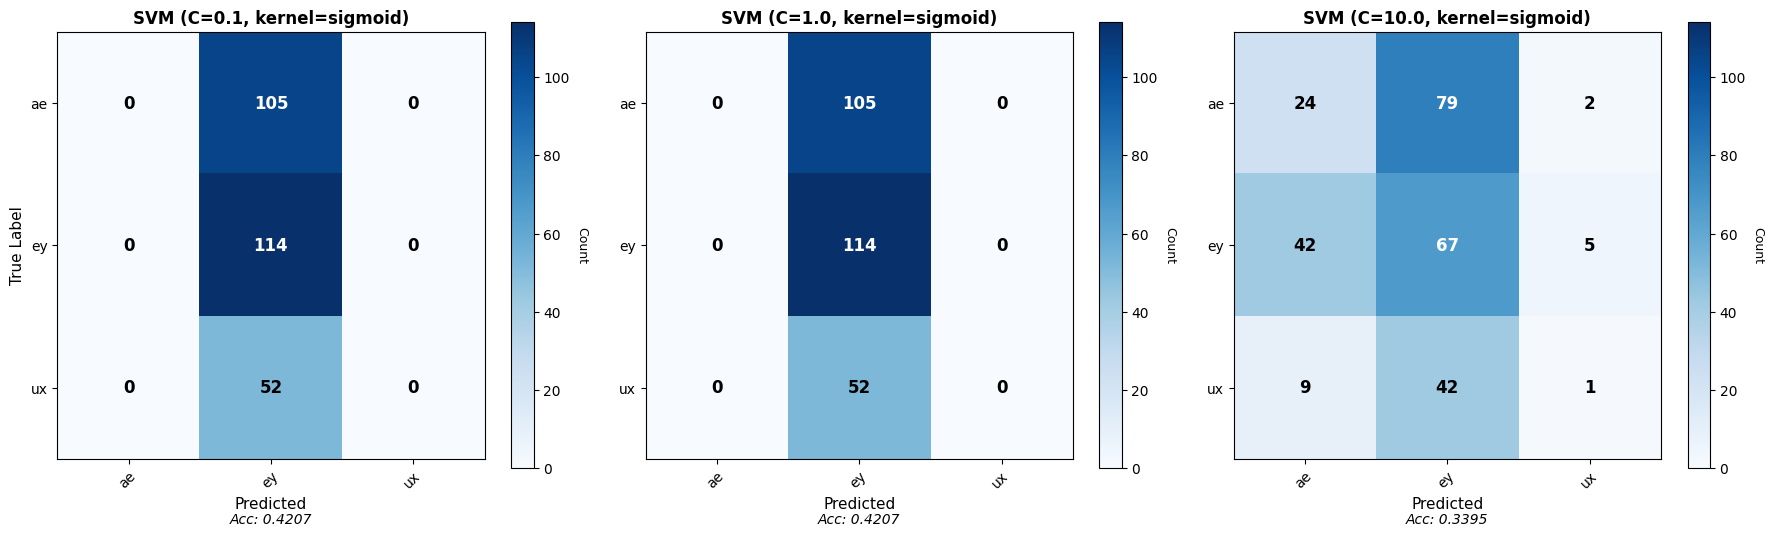

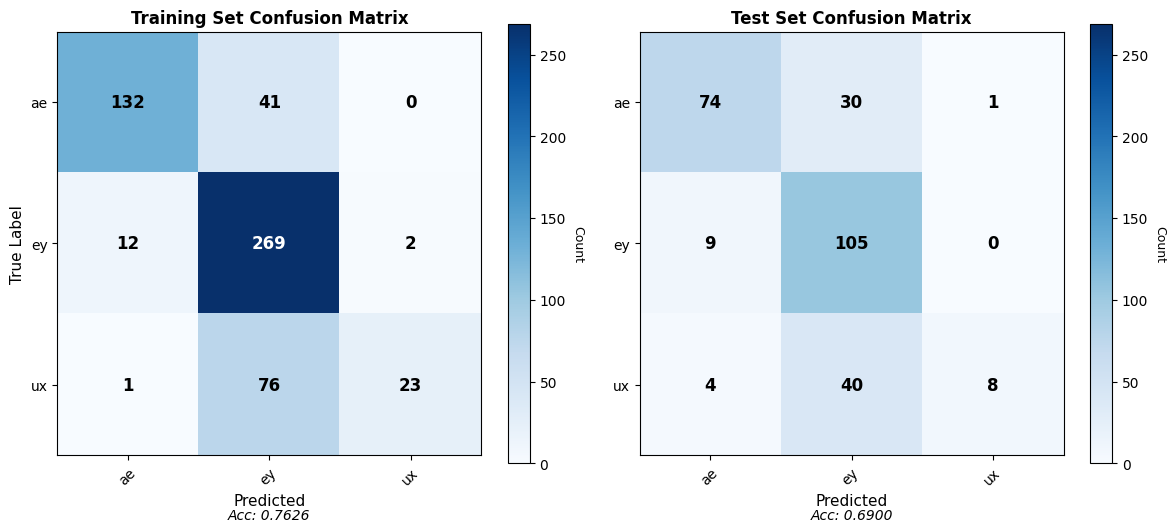

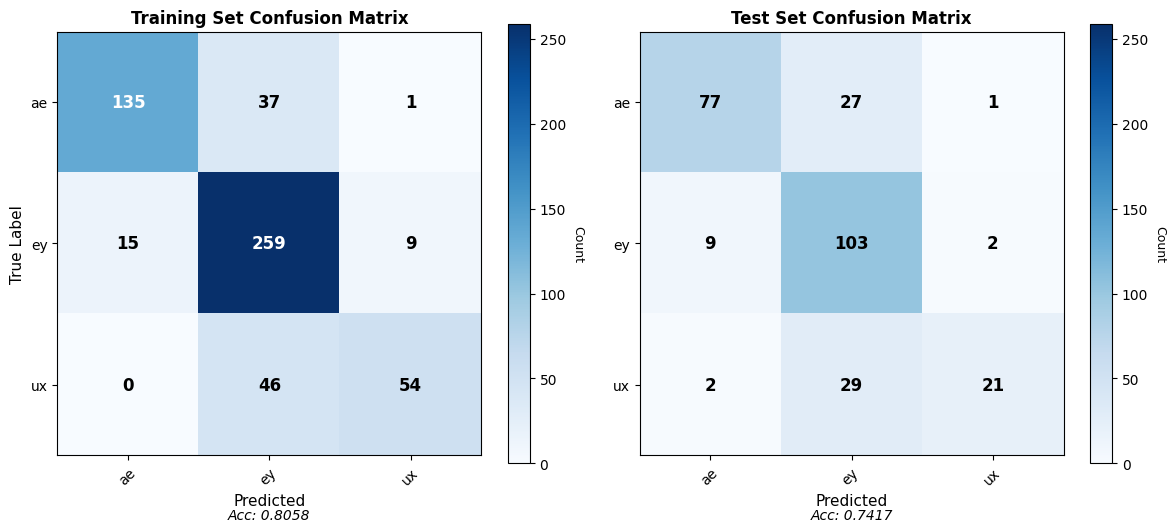

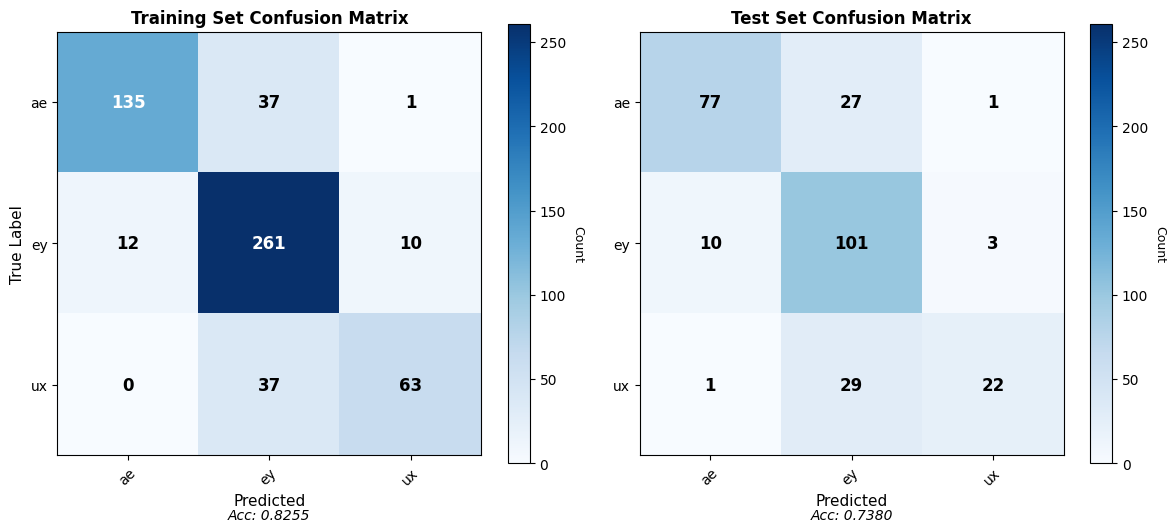

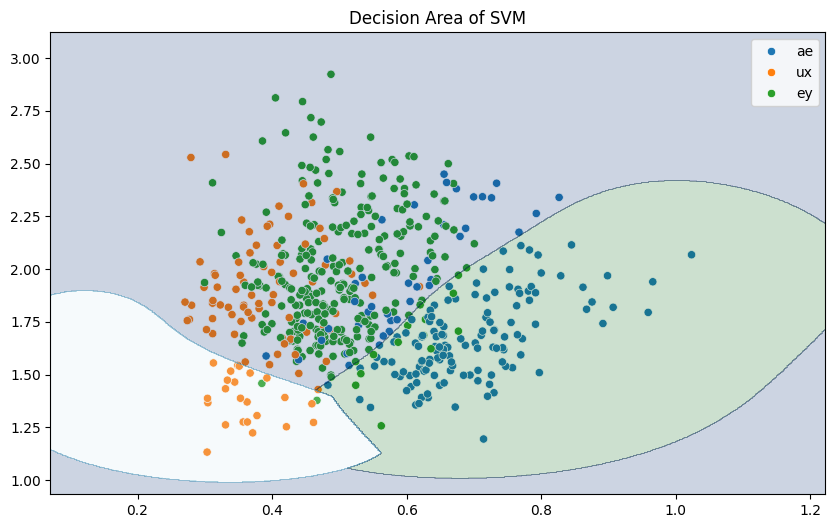

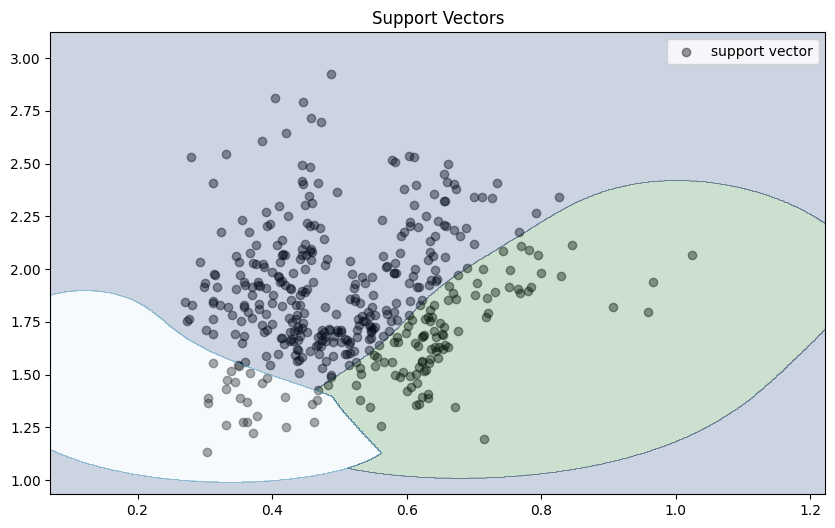

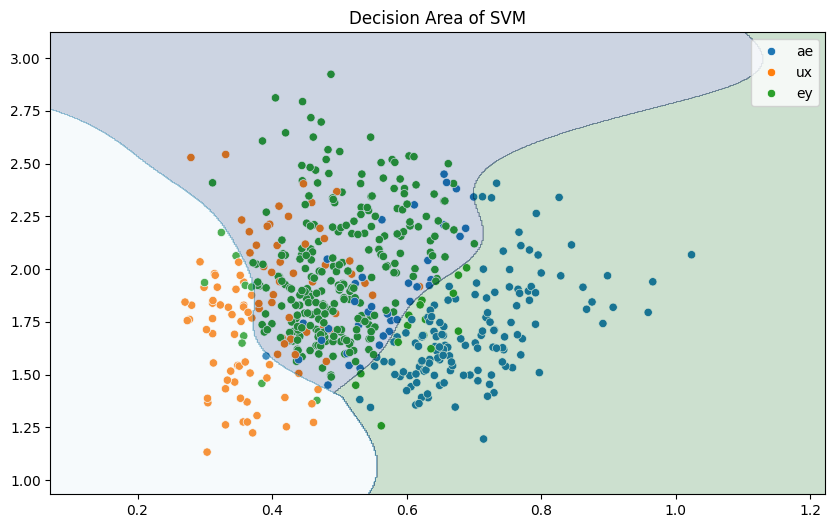

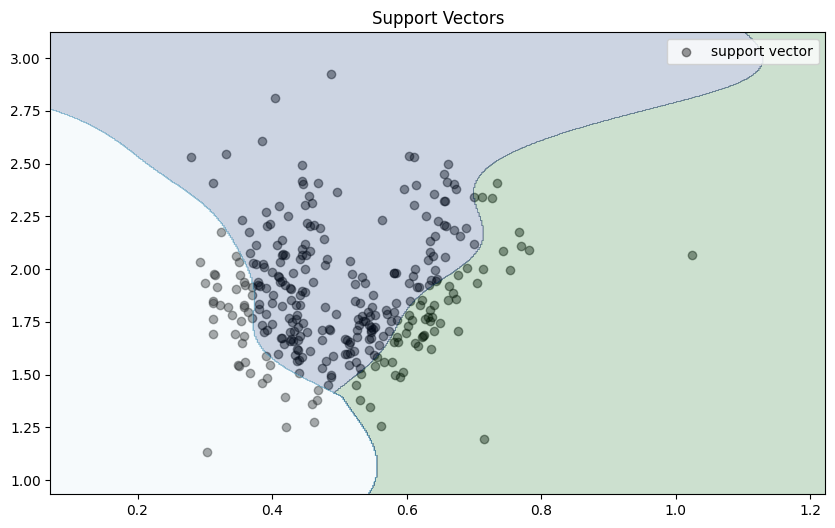

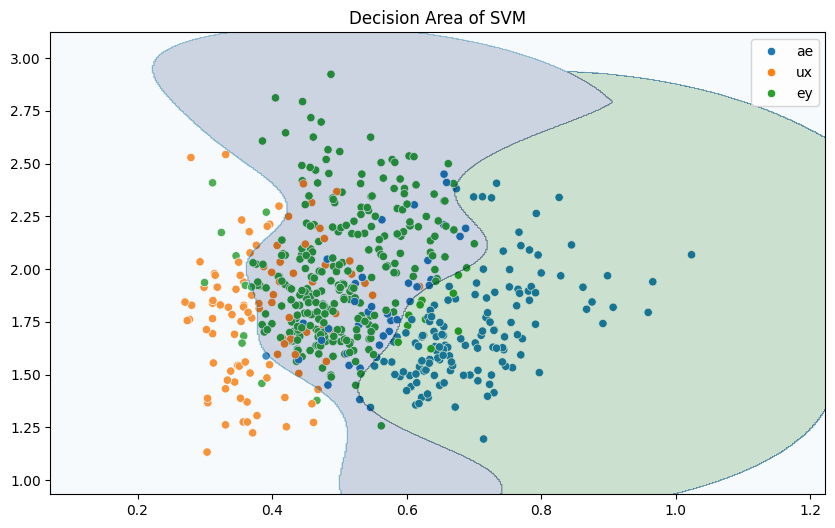

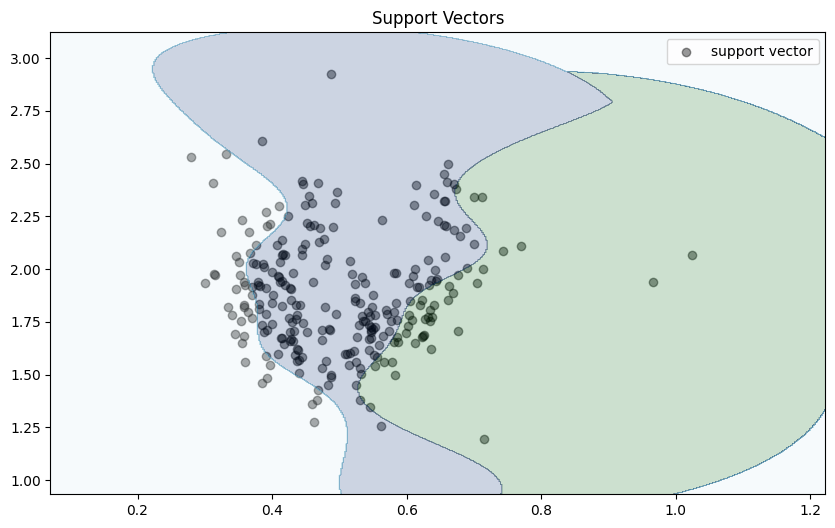

In [43]:
rbf_svms = [SVC(kernel='rbf', C=0.1, gamma=10),
            SVC(kernel='rbf', C=1.0, gamma=10),
            SVC(kernel='rbf', C=10.0, gamma=10)]

poly_svms = [SVC(kernel='poly', C=0.1, degree=3),
             SVC(kernel='poly', C=1.0, degree=3),
             SVC(kernel='poly', C=10.0, degree=3)]

sigmoid_svms = [SVC(kernel='sigmoid', C=0.1),
                SVC(kernel='sigmoid', C=1.0),
                SVC(kernel='sigmoid', C=10.0)]

train_and_compare_svms(linear_svms, x_test, y_test, x_train, y_train)
train_and_compare_svms(rbf_svms, x_test, y_test, x_train, y_train)
train_and_compare_svms(poly_svms, x_test, y_test, x_train, y_train)
train_and_compare_svms(sigmoid_svms, x_test, y_test, x_train, y_train)

# Evaluate train and test performance for RBF for different C
eval_train_and_test_performance(rbf_svms[0], x_train, y_train, x_test, y_test)
eval_train_and_test_performance(rbf_svms[1], x_train, y_train, x_test, y_test)
eval_train_and_test_performance(rbf_svms[2], x_train, y_train, x_test, y_test)

# RBF, C = 0.1
Plot_SVM_decision_regions(rbf_svms[0], x_train, y_train)
Plot_Support_Vectors(rbf_svms[0], x_train)
# RBF, C = 1.0
Plot_SVM_decision_regions(rbf_svms[1], x_train, y_train)
Plot_Support_Vectors(rbf_svms[1], x_train)
# RBF, C = 10.0
Plot_SVM_decision_regions(rbf_svms[2], x_train, y_train)
Plot_Support_Vectors(rbf_svms[2], x_train)


For the RBF kernel, varying C gives different results depending on gamma. For gamma=10, when going from C=0.1 to C=10.0, the performance on both sets increase. The increase is larger on the test set.
When going from C=1.0 to C=10.0, the performance increases on the training set, but decreases slightly on the test set.